# Preprocessing of zUMIs output for use in anlysis
__follows sequencing>Bcl2fastq>zUMIs pipline as noted under "Methods"__


__End result is a Scanpy structure used in P02_CommonSpace.ipynb__

## load packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
from anndata import AnnData
from scipy.spatial.distance import correlation, cosine, euclidean
import matplotlib.pyplot as plt
import copy as copy

os.environ['R_HOME'] = r'C:\Program Files\R\R-4.0.2' # rpy2 fix for windows, update based on machine R install location
os.environ['R_USER'] = r'D:\anaconda3\envs\malaria\Lib\site-packages\rpy2' # rpy2 fix for windows, update based on machine rpy2 install location
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import STAP
import rpy2.robjects as robjects
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

import biomart
from biomart import BiomartServer

# note, you need the "functions.py" file in the same directory as this notebook
import functions
from functions import zumis_output2pandas

def grep(l, s):
    return [i for i in l if s in i]

D:\anaconda3\envs\malaria\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
# NOTE! This code is based on Raw mRNA sequencing data.
# Files have been deposited in the GenBank GEO database under accession code GSEXXXXXXX
# and should be downladed prior to running this script
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSEXXXXXXX

# insert raw data folder (bcl2fastq output)
raw_data_path = input("Insert raw data folder:");

if os.path.isdir(raw_data_path):
    print("Great!")
else:
    print("no directory found")

Insert raw data folder: X:\Common\Lab_Papers\Malaria\Paper_data\zUMIs_output


Great!


## Read and concatenate the results of zUMIs into a single data set
__Includes Background substraction__

In [3]:
#       1. read RDS files
#       2. name columns according to file name
#       3. remove background based on specific cell identeties (note min/max values to consider as "empty")
#       4. repeat and conctnate for all files in directory
#       5. replace NaN with 0
save_list = dir()
seq_data_all = pd.DataFrame()
bg_cells_all = 0
seq_data_list = []
bg_cell_list = [] # used in EER
for file in os.listdir(raw_data_path):
    if file.endswith("dgecounts.rds"):
        seq_data = zumis_output2pandas(raw_data_path+'\\'+file)
        background_cells = seq_data.sum(axis='rows')<1000 # find cells with total reads<1000, validated independently
        bg = seq_data.iloc[:,background_cells.array]
        seq_data = seq_data.sub(bg.mean(axis='columns'), axis='rows') #subtract mean of bg cells by gene
        seq_data[seq_data<0] = 0
        seq_data_list.append(seq_data)
        bg_cell_list.append(background_cells)

In [4]:
# conctnate all plates
seq_data_all = seq_data_all.join(seq_data_list, how='outer')
seq_data_all = seq_data_all.fillna(0)

In [5]:
bg_cells_all = pd.concat(bg_cell_list)

In [6]:
pd.DataFrame(seq_data_all.index).to_csv('processed_data/conctnated_bg_subtracted_ensmble_names.csv')

## Convert gene names to common

In [7]:
# CALL bimoart datasets
# Use pre-made gene ID database in CSV generated in R (biomaRt package, see code input_data/R01_biomart)

# Mus musculus [Ensembl ver 96]
mousegenes = pd.read_csv('input_data/ensembl_96_MUS_GRCm38p6_geneID-name.csv',header=0)

# Plasmodium berghei ANKA [EnsemblProtists ver 48] 
pbagenes = pd.read_csv('input_data/protists_ensembl_48_PBANKA_geneID-name.csv',header=0)

# combine
genelist = pd.concat([mousegenes,pbagenes])
genelist = genelist.set_index('ensembl_gene_id')

In [8]:
#replace gene_name index from ensmbl to common
subset = genelist.loc[seq_data_all.index & genelist.index]
seq_data_all = seq_data_all.join(subset['external_gene_name'])
seq_data_all = seq_data_all.set_index('external_gene_name')
seq_data_all

,AACAGCT_IMM-aug20_M13_P1_36hpi,AACATCG_IMM-aug20_M13_P1_36hpi,AACCTTG_IMM-aug20_M13_P1_36hpi,AACGGTG_IMM-aug20_M13_P1_36hpi,AACGTTC_IMM-aug20_M13_P1_36hpi,AACTCGT_IMM-aug20_M13_P1_36hpi,AAGACTC_IMM-aug20_M13_P1_36hpi,AAGCCTT_IMM-aug20_M13_P1_36hpi,AAGGCTA_IMM-aug20_M13_P1_36hpi,AAGGTAC_IMM-aug20_M13_P1_36hpi,...,TTCAAGC_IMM-nov18_M4_P4_2hpi,TTCAGGA_IMM-nov18_M4_P4_2hpi,TTCAGTC_IMM-nov18_M4_P4_2hpi,TTCATGG_IMM-nov18_M4_P4_2hpi,TTCCTGA_IMM-nov18_M4_P4_2hpi,TTGCACC_IMM-nov18_M4_P4_2hpi,TTGCAGA_IMM-nov18_M4_P4_2hpi,TTGCCAG_IMM-nov18_M4_P4_2hpi,TTGCCTA_IMM-nov18_M4_P4_2hpi,TTGGTCA_IMM-nov18_M4_P4_2hpi
external_gene_name,,,,,,,,,,,,,,,,,,,,,
berg02:tRNA:rfamscan:568726-568798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
berg02:tRNA:rfamscan:569318-569389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
berg03:tRNA:rfamscan:46038-46109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
berg04:tRNA:rfamscan:398679-398751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
berg04:tRNA:rfamscan:399257-399330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm48662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm2140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm49170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## exclude pseudo genes

In [9]:
# find pseudogenes in subset of aligned genes
indices = [i for i, s in enumerate(subset['gene_biotype']) if 'pseudogene' in s]
pseudogenes = subset.iloc[indices]

# subset seq_data_all df
seq_data_all = seq_data_all[~seq_data_all.index.isin(pseudogenes['external_gene_name'])]

## Clear residuals

In [10]:
save_list.append("seq_data_all")
save_list.append("save_list")
save_list.extend(["pbagenes","mousegenes","genelist","bg_cells_all"])

for name in dir():
    if name not in save_list:
        del globals()[name]

for name in dir():
    if name not in save_list:
        del locals()[name]

## Aggregate duplicat gene-id

In [11]:
# list duplicates
dup = seq_data_all.index[seq_data_all.index.duplicated()]

seq_data_all = seq_data_all.groupby('external_gene_name').sum().reset_index()
seq_data_all = seq_data_all.set_index('external_gene_name')

seq_data_all.loc[dup.array,:]

,AACAGCT_IMM-aug20_M13_P1_36hpi,AACATCG_IMM-aug20_M13_P1_36hpi,AACCTTG_IMM-aug20_M13_P1_36hpi,AACGGTG_IMM-aug20_M13_P1_36hpi,AACGTTC_IMM-aug20_M13_P1_36hpi,AACTCGT_IMM-aug20_M13_P1_36hpi,AAGACTC_IMM-aug20_M13_P1_36hpi,AAGCCTT_IMM-aug20_M13_P1_36hpi,AAGGCTA_IMM-aug20_M13_P1_36hpi,AAGGTAC_IMM-aug20_M13_P1_36hpi,...,TTCAAGC_IMM-nov18_M4_P4_2hpi,TTCAGGA_IMM-nov18_M4_P4_2hpi,TTCAGTC_IMM-nov18_M4_P4_2hpi,TTCATGG_IMM-nov18_M4_P4_2hpi,TTCCTGA_IMM-nov18_M4_P4_2hpi,TTGCACC_IMM-nov18_M4_P4_2hpi,TTGCAGA_IMM-nov18_M4_P4_2hpi,TTGCCAG_IMM-nov18_M4_P4_2hpi,TTGCCTA_IMM-nov18_M4_P4_2hpi,TTGGTCA_IMM-nov18_M4_P4_2hpi
external_gene_name,,,,,,,,,,,,,,,,,,,,,
Atp5o,2.901639,0.0,0.0,1.901639,0.901639,1.901639,0.901639,2.901639,0.0,0.00000,...,0.996785,2.996785,0.0,0.0,3.996785,0.0,0.0,0.0,0.0,0.0
Igsf5,0.000000,0.0,0.0,2.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Myl12b,2.000000,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.00000,...,7.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
Arhgap26,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4930594M22Rik,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Tmem147os,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Gm35558,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Gm35558,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Ggnbp1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## create "Infected" tag list

In [12]:
# read refrence data from input folder
plate_gfp_rows = pd.read_csv('input_data/infected_rows_metadata.csv',index_col='PLATE') # sorting scheme of infected cells
well_BC = pd.read_csv('input_data/single_cell_384_barcodes_by_well.csv') # barcodes used in MARS-seq plates
Infected_cells = []

for plate in plate_gfp_rows.index:
    col = seq_data_all.columns[seq_data_all.columns.str.contains(plate)] #find cells from plate
    wells = []
    for rangei in plate_gfp_rows['INFECTED ROWS'][plate].split(','):
        chri = rangei[0]
        ranges = list(map(int, re.findall(r'\d+', rangei)))
        wells = wells + [f'{chri}{i}' for i in range(ranges[0], ranges[1]+1)]
    
    cells = well_BC.loc[well_BC['well'].str.contains('|'.join(wells))]['code'] #get list of relevent codes for specific plate
    Infected_cells = Infected_cells + col[col.str.contains('|'.join(cells))].format()

## Subset based EER to correct sorting errors

In [13]:
sum_series = seq_data_all.sum(axis=0)

In [14]:
pbagenes_int = [gene for gene in pbagenes['external_gene_name'] if gene in seq_data_all.index]
sum_pba_series = seq_data_all.loc[pbagenes_int].sum(axis=0)

In [15]:
def EER(vec_uninf, vec_inf):
    vec_all = np.hstack([vec_inf, vec_uninf])
    thresh_vec = np.percentile(vec_all, np.arange(1, 101))
    FPR = np.zeros(100)
    FNR = np.zeros(100)
    
    for i, thr in enumerate(thresh_vec):
        FPR[i] = np.sum(vec_uninf > thr)/len(vec_uninf)
        FNR[i] = np.sum(vec_inf < thr)/len(vec_inf)
    
    thr_ind = np.where(FNR>FPR)[0][0] 
    return thresh_vec[thr_ind]
    

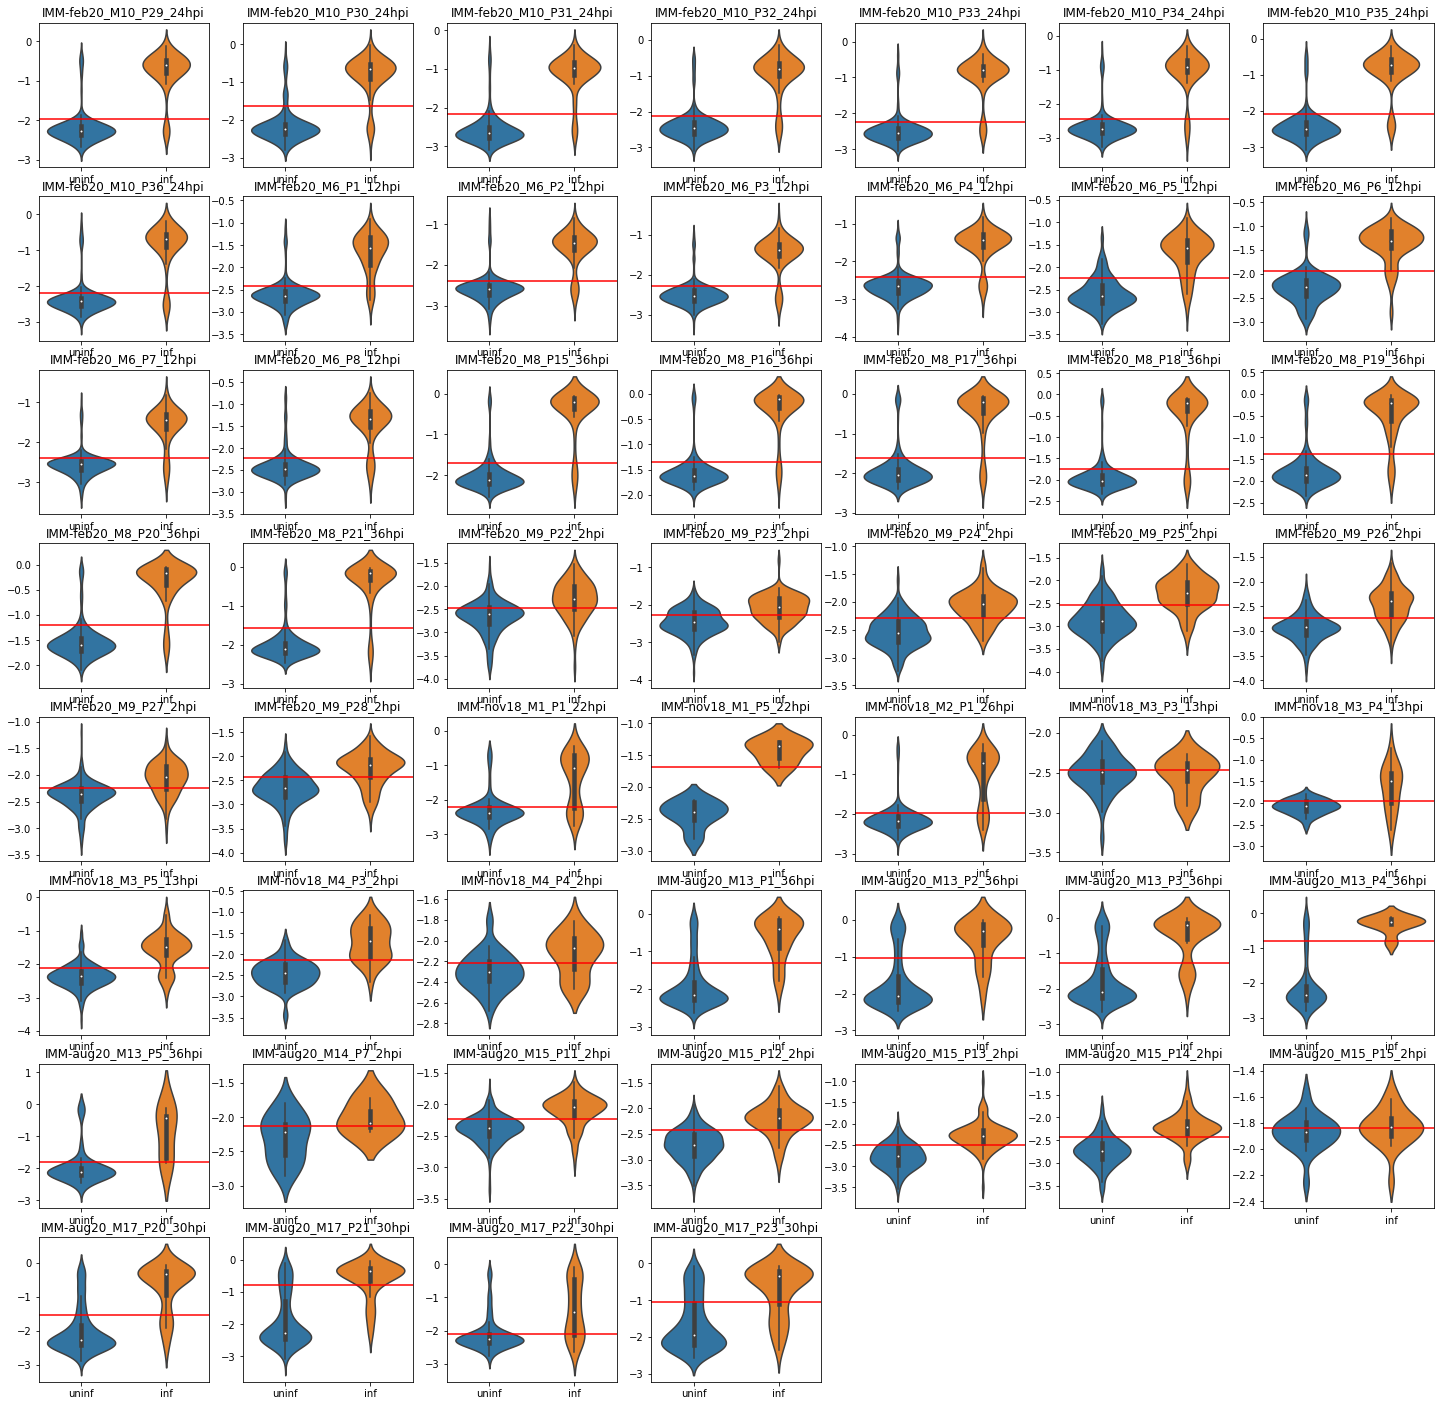

In [16]:
# collect cells IDs for cells passing log threshold procedure
eer_passed = []
plt.figure(figsize=[25,25])
count=1

for i, plate in enumerate(plate_gfp_rows.index.tolist()):
    # skip control plates
    if 'NI' in plate:
        continue
    if 'mock' in plate:
        continue
    
    # get all cells in this plate
    in_plate_list = [x for x in seq_data_all.columns.tolist() if x.endswith(plate)]
    # keep only cells which pass background threshold
    in_plate_bg_list = [x for x in in_plate_list if not bg_cells_all.loc[x]]
    in_plate_bg_inf_list = [x for x in in_plate_bg_list if x in Infected_cells]
    in_plate_bg_uninf_list = [x for x in in_plate_bg_list if x not in Infected_cells]
    
    # get sums for these cells, infected
    sum_vec_inf = sum_series.loc[in_plate_bg_inf_list].values
    sum_pba_vec_inf = sum_pba_series.loc[in_plate_bg_inf_list].values
    vec_inf = np.log10((1+sum_pba_vec_inf)/(1+sum_vec_inf))
    inf_df = pd.DataFrame(data=np.vstack([sum_vec_inf, sum_pba_vec_inf,  vec_inf]).T, index=in_plate_bg_inf_list, columns=['sum_all', 'sum_pba', 'log_ratio'])   
    
    # uninfected
    sum_vec_uninf = sum_series.loc[in_plate_bg_uninf_list].values
    sum_pba_vec_uninf = sum_pba_series.loc[in_plate_bg_uninf_list].values
    vec_uninf = np.log10((1+sum_pba_vec_uninf)/(1+sum_vec_uninf))
    uninf_df = pd.DataFrame(data=np.vstack([sum_vec_uninf, sum_pba_vec_uninf,  vec_uninf]).T, index=in_plate_bg_uninf_list, columns=['sum_all', 'sum_pba', 'log_ratio'])
    
    # get EER threshold
    thr = EER(vec_uninf, vec_inf)
    
    # add passing cells to list
    # infected
    eer_passed += inf_df[inf_df['log_ratio']>thr].index.tolist()
    eer_passed += uninf_df[uninf_df['log_ratio']<thr].index.tolist()
    
    plt.subplot(8,7,(count))
    plt.title(plate)
    sns.violinplot(['uninf']*len(vec_uninf) + ['inf']*len(vec_inf),np.hstack([vec_uninf, vec_inf]))
    plt.axhline(thr,color="red")
    count += 1

plt.show()

In [17]:
# add back control plates and subset dataframe
allnames = seq_data_all.columns.values.tolist()
eer_passed += grep(allnames,'NI')
eer_passed += grep(allnames,'mock')

seq_data_all = seq_data_all.loc[:,eer_passed]
seq_data_all

,AACCTTG_IMM-feb20_M10_P29_24hpi,AAGACTC_IMM-feb20_M10_P29_24hpi,AAGGCTA_IMM-feb20_M10_P29_24hpi,AATGCCG_IMM-feb20_M10_P29_24hpi,ACAATCG_IMM-feb20_M10_P29_24hpi,ACACGTG_IMM-feb20_M10_P29_24hpi,ACAGCTC_IMM-feb20_M10_P29_24hpi,ACATGCT_IMM-feb20_M10_P29_24hpi,ACCGATC_IMM-feb20_M10_P29_24hpi,ACGATGC_IMM-feb20_M10_P29_24hpi,...,TTCAAGC_IMM-aug20_M16_P19_mock,TTCAGGA_IMM-aug20_M16_P19_mock,TTCAGTC_IMM-aug20_M16_P19_mock,TTCATGG_IMM-aug20_M16_P19_mock,TTCCTGA_IMM-aug20_M16_P19_mock,TTGCACC_IMM-aug20_M16_P19_mock,TTGCAGA_IMM-aug20_M16_P19_mock,TTGCCAG_IMM-aug20_M16_P19_mock,TTGCCTA_IMM-aug20_M16_P19_mock,TTGGTCA_IMM-aug20_M16_P19_mock
external_gene_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,5.0,1.0,0.0,3.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,4.0,0.0
0610009B22Rik,0.0,0.0,0.0,0.958333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0610009E02Rik,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610009L18Rik,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0610010F05Rik,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s25,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n-R5s46,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n-R5s56,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Remove PBA background per plate


In [18]:
# removes background aligned PBANKA reads based on the 99th percentile in Uninfected cells

# create meta data for use now and later in Scanpy
bc = []
rn = []
mus =[]
pl = []
tm = []

for i in seq_data_all.columns:
    [barcode, run, mouse, plate, hpi] = i.split('_')
    bc.append(barcode)
    rn.append(run)
    mus.append(mouse)
    pl.append(plate)
    tm.append(hpi)

marker = [i + j for i, j in zip(mus, pl)] #unique identifier for plate - M[X]P[Y]

# tag infected
infected = seq_data_all.columns.str.contains('|'.join(Infected_cells)).tolist()
# fix mock|NI tag
indNI=[i in "NI|mock" for i in tm]
for ind in np.where(indNI)[0]:
    infected[ind] = False

In [19]:
# mark plates without infected cells to "skip"
skip = np.unique([i for (i, v) in zip(marker, indNI) if v])

In [20]:
# remove background in a plate specific manner
for plate in np.unique(marker):
    if plate in skip:
        pass
    else:
        ind_col = [i in plate for i in marker]
        ind_row = seq_data_all.index.intersection(pbagenes.external_gene_name)

        PBAbg = seq_data_all.loc[ind_row,ind_col&~np.array(infected)].quantile(.99,axis=1)
        seq_data_all.loc[ind_row,ind_col]=seq_data_all.loc[ind_row,ind_col].sub(PBAbg, axis=0)
seq_data_all[seq_data_all<0]=0

# Move to Scanpy and save data

In [21]:
# common space (CS)
CS_data = AnnData(seq_data_all.values.T)
CS_data.obs_names = seq_data_all.columns.tolist()
CS_data.var_names = seq_data_all.index.tolist()

## add cell meta data

In [22]:
CS_data.obs['barcode'] = bc
CS_data.obs['mouse'] = mus
CS_data.obs['marker'] = marker
CS_data.obs['time'] = tm
CS_data.obs['infected'] = infected

In [23]:
# add another time label grouping together similar time points
coarse_time = []
for tp in CS_data.obs['time']:
    if tp in ['2hpi']:
        coarse_time.append('2hpi')
    elif tp in ['12hpi', '13hpi']:
        coarse_time.append('12hpi')
    elif tp in ['22hpi', '24hpi', '26hpi']:
        coarse_time.append('24hpi')
    elif tp in ['30hpi']:
        coarse_time.append('30hpi')
    elif tp in ['36hpi']:
        coarse_time.append('36hpi')
    else: coarse_time.append('NI')
CS_data.obs['coarse_time'] = coarse_time

In [24]:
# Infer spatial coordinates on Porta-Central axis per cell based on landmark genes.

# Periportal genes
pn_genes = ['Apof',
             'Apom',
             'Asgr2',
             'Atp5a1',
             'C1s1', 
             'C8b',
             'Cpt2',
             'Tkfc',
             'Eef1b2',
             'Fads1',
             'Gc',
             'Hsd17b13',
             'Ifitm3',
             'Igf1',
             'Igfals',
             'Ndufb10',
             'Pigr',
             'S100a1',
             'Serpina1c',
             'Serpina1e',
             'Serpind1',
             'Serpinf1',
             'Uqcrh',
             'Vtn',
             'Arg1',
             'Cps1']

# Pericentral genes
cv_genes = ['Alad',
             'Aldh1a1',
             'Nat8f2', 
             'Cpox',
             'Cyb5a', 
             'Cyp3a11',
             'Lect2',
             'Mgst1',
             'Prodh',
             'Slc16a10']

# calculate Zonation score (=eta) is between 1 to 0, 1 being very periportal
CS_data.obs['eta'] = np.sum(CS_data[:, pn_genes].X, axis=1).toarray() / np.sum(CS_data[:, cv_genes+pn_genes].X, axis=1).toarray()

D:\anaconda3\envs\malaria\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


## add gene meta data

In [25]:
CS_data.var['org']=''
CS_data.var['biotype']=''
for i,g in enumerate(CS_data.var_names.values):
    # Add Var metadata - organism
    if g in mousegenes.external_gene_name.tolist():
        CS_data.var['org'][i] = 'mouse'
    if g in pbagenes.external_gene_name.tolist():
        CS_data.var['org'][i] = 'PBA'  
    # Add Var metadata - biotype 
    if len(genelist.gene_biotype[genelist.external_gene_name==g].values)!=0:
        CS_data.var['biotype'][i] = genelist.gene_biotype[genelist.external_gene_name==g].values[0]

## save data structure

In [26]:
CS_data.write('processed_data/CS_data.h5ad')

... storing 'barcode' as categorical
... storing 'mouse' as categorical
... storing 'marker' as categorical
... storing 'time' as categorical
... storing 'coarse_time' as categorical
... storing 'org' as categorical
... storing 'biotype' as categorical
